🛠️ Preparação dos Dados

Importando as bibliotecas do projeto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

c:\Users\curso\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


Extração do Arquivo Tratado

In [4]:
import pandas as pd
telecom_dados = pd.read_csv('TelecomX_Data_Clean.csv', sep=';')
telecom_dados.head()


,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,DailyCharges,MonthlyCharges,AvgServiceCost,TotalCharges,ServiceCount,TenureGroup,Churn_binary
0,No,Female,No,Yes,Yes,9,Yes,No,Dsl,No,...,One year,Yes,Mailed check,"65,92","65,6","16,4","593,3",4,0–12,0
1,No,Male,No,No,No,9,Yes,Yes,Dsl,No,...,Month-to-month,No,Mailed check,"60,27","59,9","29,95","542,4",2,0–12,0
2,Yes,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,"70,21","73,9","36,95","280,85",2,0–12,1
3,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,"95,22","98,0","19,6","1237,85",5,13–24,1
4,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Mailed check,"89,13","83,9","27,96666666666667","267,4",3,0–12,1


In [13]:
telecom_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6952 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Churn             6952 non-null   object
 1   Gender            6952 non-null   object
 2   SeniorCitizen     6952 non-null   object
 3   Partner           6952 non-null   object
 4   Dependents        6952 non-null   object
 5   Tenure            6952 non-null   int64 
 6   PhoneService      6952 non-null   object
 7   MultipleLines     6952 non-null   object
 8   InternetService   6952 non-null   object
 9   OnlineSecurity    6952 non-null   object
 10  OnlineBackup      6952 non-null   object
 11  DeviceProtection  6952 non-null   object
 12  TechSupport       6952 non-null   object
 13  StreamingTV       6952 non-null   object
 14  StreamingMovies   6952 non-null   object
 15  Contract          6952 non-null   object
 16  PaperlessBilling  6952 non-null   object
 17  PaymentMethod     6

In [37]:
telecom_dados = pd.read_csv('TelecomX_Data_Clean.csv', sep=';')
print(telecom_dados.columns)
print(telecom_dados['Churn'].unique())
print(telecom_dados['Churn'].value_counts())

Index(['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'DailyCharges', 'MonthlyCharges', 'AvgServiceCost', 'TotalCharges',
       'ServiceCount', 'TenureGroup', 'Churn_binary'],
      dtype='object')
['No' 'Yes']
Churn
No     5163
Yes    1869
Name: count, dtype: int64


Remoção de Colunas Irrelevantes

In [10]:
#Total de Valores Faltantes
print(f'Total de Valores faltantes na tabela: \n{telecom_dados.isnull().sum()}')

Total de Valores faltantes na tabela: 
Churn                0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
DailyCharges         0
MonthlyCharges       0
AvgServiceCost      80
TotalCharges         0
ServiceCount         0
TenureGroup          0
Churn_binary         0
dtype: int64


Encoding

In [38]:
telecom_dados['Churn_binary'].isnull()
print(telecom_dados['Churn_binary'].isnull().sum())

0


In [ ]:
# Remover linhas com valores nulos na variável alvo
telecom_dados = telecom_dados.dropna(subset=['Churn']).copy()

# Converter Churn para binário
telecom_dados['Churn_binary'] = telecom_dados['Churn'].map({'Yes': 1, 'No': 0})

# Ajuste de vírgulas para pontos em colunas numéricas que vieram como string
for col in ['TotalCharges', 'AvgServiceCost']:
    telecom_dados[col] = telecom_dados[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# Preencher valores faltantes na AvgServiceCost com mediana
telecom_dados['AvgServiceCost'] = telecom_dados['AvgServiceCost'].fillna(telecom_dados['AvgServiceCost'].median())


In [33]:
print(telecom_dados['Churn_binary'].head())
print(telecom_dados['Churn_binary'].isnull().sum())
print(telecom_dados['Churn_binary'].unique())

0    0
1    0
2    1
3    1
4    1
Name: Churn_binary, dtype: int64
0
[0 1]


Verificação da Proporção de Evasão

In [39]:
telecom_churn = telecom_dados['Churn_binary'].mean()
print(f"Proporção de clientes que evadiram: {telecom_churn:.2%}")

Proporção de clientes que evadiram: 26.58%


Balanceamento de Classes (opcional )

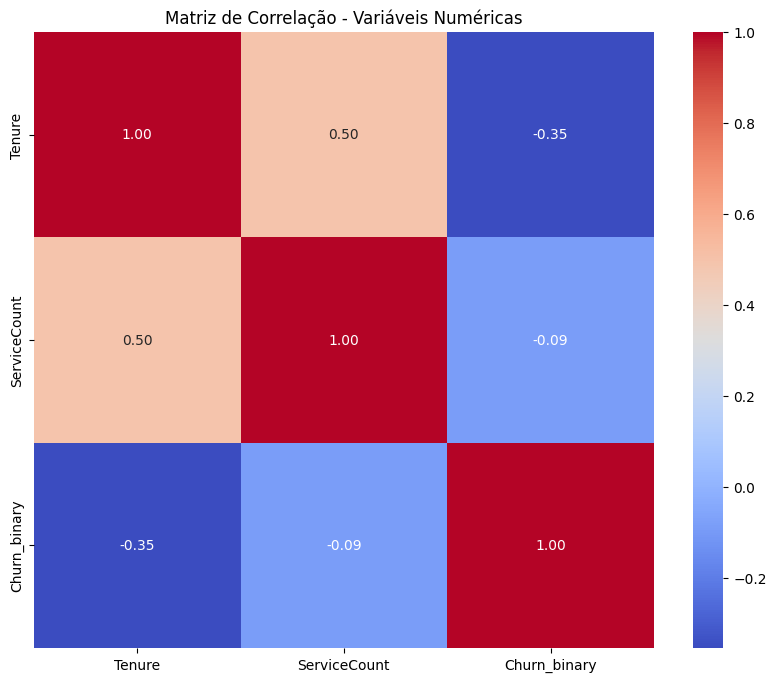

In [40]:
corr = telecom_dados.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()

Normalização ou Padronização (se necessário)

🎯 Correlação e Seleção de Variáveis

Análise de Correlação

Análises Direcionadas

🛠️ Preparação dos Dados

Separação de Dados

Criação de Modelos

📋  Interpretação e Conclusões

Análise de Importância das Variáveis

Conclusão